In [233]:
#For surf features using we need this version it is only available til python 3.7
!pip install -r ../requirements.txt

In [234]:
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from active_semi_clustering.semi_supervised.pairwise_constraints import PCKMeans,COPKMeans, MPCKMeansMF, MPCKMeans
from active_semi_clustering.active.pairwise_constraints import ExampleOracle, ExploreConsolidate, MinMax
import active_semi_clustering.active.pairwise_constraints.random
import pickle
import shap
import imagehash
from PIL import Image

In [235]:
builder = tfds.builder('voc/2007')
builder.download_and_prepare()
datasets = builder.as_dataset()
train_data, val_data, test_data = datasets['train'], datasets['validation'], datasets['test']

In [236]:
_VOC_LABELS = (
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
)

In [237]:

LOAD_CONSTRAINTS=False

# Disable enable Features here

CLD_ENABLED = True

EFFNET_ENABLED = True

HASHING_ENABLED = False

SURF_ENABLED=True

enabled_names = []
feature_weights=[]

if CLD_ENABLED:
    enabled_names.append("cld")
    feature_weights.append(0.01)
if EFFNET_ENABLED:
    enabled_names.append("effnet")
    feature_weights.append(1)
if HASHING_ENABLED:
    enabled_names.append("hash")
    feature_weights.append(0.01)
if SURF_ENABLED:
    enabled_names.append("surf")
    feature_weights.append(0.01)
    
has_used_loaded_constraints=True
    


In [238]:
#Load using Pickle
if  LOAD_CONSTRAINTS:
    try:
        with open('data/expert_weights', 'rb') as handle:
             loaded_constraints=pickle.load(handle)
        has_used_loaded_constraints=False
    except FileNotFoundError:
            loaded_constraints=([],[])
else:
    loaded_constraints=([],[])


In [239]:
inverse = np.array([[0, 1, 5, 6, 14, 15, 27, 28],
                    [2, 4, 7, 13, 16, 26, 29, 42],
                    [3, 8, 12, 17, 25, 30, 41, 43],
                    [9, 11, 18, 24, 31, 40, 44, 53],
                    [10, 19, 23, 32, 39, 45, 52, 54],
                    [20, 22, 33, 38, 46, 51, 55, 60],
                    [21, 34, 37, 47, 50, 56, 59, 61],
                    [35, 36, 48, 49, 57, 58, 62, 63]]).astype(int)
zigzag_flat = np.argsort(inverse, axis=None).astype(int)


def color_layout_descriptor(im):
    # numpy is a bit faster than using tensors
    im = np.array(im)
    # could do these as a hyperparameter
    rows = 8
    columns = 8
    small_image = np.zeros((rows, columns, 3))
    height, width = im.shape[:2]
    percentage_w = width / columns
    percentage_h = height / rows
    for row in range(rows):
        for column in range(columns):
            # Note this partion should propably be checked against a reference implementation. However the difference should be minimal
            portion = im[int(percentage_h * row):int(percentage_h * (row + 1)),
                      int(percentage_w * column):int(percentage_w * (column + 1))]
            small_image[row, column] = np.mean(np.mean(portion, axis=0), axis=0)
    small_image = cv.cvtColor(small_image.astype(np.uint8), cv.COLOR_BGR2YCrCb)
    y, cr, cb = cv.split(small_image)
    dct_y = cv.dct(y.astype(np.float32))
    dct_cb = cv.dct(cb.astype(np.float32))
    dct_cr = cv.dct(cr.astype(np.float32))
    return np.concatenate((dct_y.flatten()[zigzag_flat], dct_cb.flatten()[zigzag_flat], dct_cr.flatten()[zigzag_flat]))

In [240]:
for x in train_data:
    print(x.keys())
    break

dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects'])


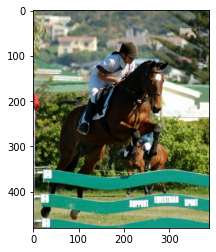

In [241]:
for x in train_data:
    image = x["image"]
    plt.imshow(image)
    plt.show()
    # print(ColorLayoutDescripter(image))
    break

In [242]:
effnet = tf.keras.applications.EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling="avg",
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
)


In [243]:
# trying out image hashing
def difference_hashing(im):
    hashed_img = imagehash.dhash(Image.fromarray(im.numpy().astype(np.uint8)))

    imhash = np.array(list(str(hashed_img)))
    
    converted_hash = []
    n = 0
    for i in imhash:
        converted_hash.append(float.fromhex(imhash[n]))
        n = n + 1
    
    out_hash = np.array(converted_hash)
    #print("image hash:", imhash)
    #print("hash converted to array:", out_hash)
    
    return out_hash

#stuff to try out
    # change 1 pixel to see, if it has an impact
    #img_copy = im.numpy().copy()
    #img_copy[0][100] = np.array([255,255,255])
    #hashed_img2 = imagehash.dhash(Image.fromarray(img_copy)) # test for change of 1 pixel
    
    # convert to gray value image, to see if it has an impact
    #im2 = cv.cvtColor(im.numpy(), cv.COLOR_BGR2GRAY)
    #hashed_img2 = imagehash.dhash(Image.fromarray(im2)) # test for gray value image
    
    #dist = np.linalg.norm(hashed_img - hashed_img2)
    #print("L2 dist:", dist)
    #print("Type:", type(hashed_img))
    
#98c8460e3e2d367a -> normal
#98c8460e3e2d367a -> 1 pixel changed
#98c8c60e1e2d363a -> converted to gray scale, diff of 3 to original

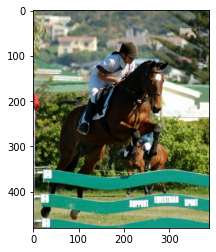

[ 9.  8. 12.  8.  4.  6.  0. 14.  3. 14.  2. 13.  3.  6.  7. 10.]


In [244]:
for x in train_data:
    image = x["image"]
    plt.imshow(image)
    plt.show()
    print(difference_hashing(image))
    break

In [245]:
#Preparing surf features
image_list = list(train_data.map(lambda x: x['image']).as_numpy_iterator())
surf = cv.xfeatures2d.SURF_create(hessianThreshold = 500)
def calculate_surf_image(surf,img):
    kp = surf.detect(img,None)
    kp, des = surf.compute(img, kp)
    return des

def calculate_surf(image_list):
    des=list(map(lambda x : calculate_surf_image(surf,x),image_list))
    return np.vstack(des)



In [246]:
descriptors=calculate_surf(image_list)
descriptors.shape

(1985414, 64)

In [247]:
from sklearn.cluster import MiniBatchKMeans
k_means_surf=MiniBatchKMeans(n_clusters=200)
k_means_surf.fit(descriptors)


MiniBatchKMeans(n_clusters=200)

In [248]:
def calculate_bow(ima):
    histogram=np.zeros((200))
    des=calculate_surf_image(surf,ima.numpy().astype(np.uint8))
    index=k_means_surf.predict(des)
    np.add.at(histogram,index,1)
    return histogram


In [249]:
#histogram=histogram/histogram.sum(axis=1,keepdims=True)
#for image in image_list:
    #calculate_bow(image)

In [250]:
from sklearn_extra.cluster import KMedoids

In [251]:
def get_all_features(datapoint):
    return tf.concat([datapoint[enabled_names[i]]*feature_weights[i] for i in range(len(enabled_names))],0)

#


def add_features_to_dataset(dataset,cachename):
    images = dataset.map(lambda x: x["image"])
    feature_sets = []
    # order is important here, must be same as defined in enabled_names
    if CLD_ENABLED:
        cld_features = images.map(lambda x: tf.py_function(func=color_layout_descriptor, inp=[x], Tout=np.float32),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).cache("data/"+cachename+"_cld" if cachename!=None else '').prefetch(
            tf.data.experimental.AUTOTUNE)
        feature_sets.append(cld_features)
    if EFFNET_ENABLED:
        resized_images = dataset.map(lambda x: tf.image.resize(x["image"], [240, 240])).batch(1024)
        
        effnet_features = resized_images.map(lambda x: effnet(x)).unbatch().cache("data/"+cachename+"_effnet" if cachename!=None else '').prefetch(
            tf.data.experimental.AUTOTUNE)
        feature_sets.append(effnet_features)
        
    if HASHING_ENABLED:
        hashing_features = images.map(lambda x: tf.py_function(func=difference_hashing, inp=[x], Tout=np.float32),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).cache("data/"+cachename+"_hash" if cachename!=None else '').prefetch(
            tf.data.experimental.AUTOTUNE)
        feature_sets.append(hashing_features)

    if SURF_ENABLED:
        surf_features = images.map(lambda x: tf.py_function(func=calculate_bow, inp=[x], Tout=np.float32),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).cache("data/"+cachename+"_surf" if cachename!=None else '').prefetch(
             tf.data.experimental.AUTOTUNE)
        feature_sets.append(surf_features)
        pass

    
    # We could do feature scaling here
    # this here insers the values of all featuresets into the dictionary
    complete_dataset = tf.data.Dataset.zip((dataset,) + tuple(feature_sets)).map(
        lambda x, *y: x.update({enabled_names[i]: y[i] for i in range(len(enabled_names))})\
        or x, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(lambda x:x.update({"feature":get_all_features(x)}) or x, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
    # I dediced to return dict here. They have the advantage that you can disable/add Features add will without having to condider ordering. Also we do not loose any information, which we might use later
    return complete_dataset

def extract_features_from_image():
    return


# after first run this should be cached memory (needs full run)
train_complete = add_features_to_dataset(train_data,"train")
val_complete = add_features_to_dataset(val_data, "val")




In [252]:
# forces caching
counter=0
for i in train_complete:
    counter+=1
    pass
for i in val_complete:
    pass
print(counter)

2501


In [253]:
for i in train_complete:
    print(i.keys())
    break

dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects', 'cld', 'effnet', 'surf', 'feature'])


In [254]:


def calculate_orb_image(image):
    orb= cv.ORB_create()
    kp = orb.detect(image,None)
    kp, des = orb.compute(image, kp)
    return des

def calculate_orb(image_list):
    des=list(map(lambda x : calculate_orb_image(x),image_list))
    return np.vstack(des)

descriptors=calculate_orb(image_list)




Surf does not work in newer opencv versions, so we have to use an older one or build it ourselves


In [255]:
for data in train_complete:
    x = data['image']
    print(x.shape)
    kp = surf.detect(x.numpy(), None)
    # compute the descriptors with ORB
    kp, des = surf.compute(x.numpy(), kp)
    print(len(kp))
    print(len(des[0]))
    break

(480, 389, 3)
1226
64


In [256]:
#train_knn_arr = np.array(list(train_complete.map(lambda x:x["feature"]).as_numpy_iterator()))
train_knn_arr = np.array(list(train_complete.map(lambda x:tf.reshape(tf.image.resize(x["image"],[200,200]),[-1])).as_numpy_iterator()))
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
def get_KNN_points(numb_neigh, query_point, X):
    neigh = NearestNeighbors(n_neighbors=numb_neigh).fit(X)
    dist_arr, ind_array = neigh.kneighbors(X=X[query_point].reshape(1, -1))
    return ind_array.flatten('c')

filter_ind=get_KNN_points(200,0,train_knn_arr)
filter_arr=np.zeros((train_knn_arr.shape[0]))
filter_arr[filter_ind]=1
filter_arr=tf.convert_to_tensor(filter_arr, np.uint8)
print(filter_arr)

tf.Tensor([1 0 0 ... 0 0 0], shape=(2501,), dtype=uint8)


In [257]:
train_filtered=train_complete.enumerate().filter(lambda x,y:filter_arr[x]==1).\
    map(lambda x,y:y)
train_filtered_list=list(train_filtered.as_numpy_iterator())
len(train_filtered_list)

200

In [258]:
n_cluster=20

In [259]:
import ipywidgets as widgets
import asyncio
from IPython.display import display
import time
from operator import itemgetter

#this is only an estimate because overlap is not considered
#TODO correcly calculate overlap
def calculate_label_area(objects,labels):
        obj_labels=objects["label"]
        obj_boundingbox=objects["bbox"]
        return calculate_label_area_helper(obj_labels,obj_boundingbox,labels)
    
def calculate_label_area_helper(obj_labels,obj_boundingbox,labels):
        areas=[]
        for label in labels:
            area_estimate=0
            foundbbox=[]
            for k,boundinglabel in enumerate(obj_labels):
                if(boundinglabel!=label): continue
                y_min,x_min,y_max,x_max=obj_boundingbox[k]
                #Here we could calulate the overlap to the other boxes
                area_estimate+=(y_max-y_min)*(x_max-x_min)
            areas.append(area_estimate)
        return areas 
    
def get_max_label_helper(obj_labels,obj_boundingbox,labels):
        areas=calculate_label_area_helper(obj_labels,obj_boundingbox,labels)
        max_arg,_=max(enumerate(areas), key=itemgetter(1))
        return labels[max_arg]

def get_max_label(objects,labels):
        obj_labels=objects["label"]
        obj_boundingbox=objects["bbox"]
        return get_max_label_helper(obj_labels,obj_boundingbox,labels)

from active_semi_clustering.active.pairwise_constraints.example_oracle import MaximumQueriesExceeded


class LabelOracle:
    def __init__(self, data, max_queries_cnt=100,max_querry=False,area_difference_weight=1.0,different_labels_weight=2):
        self.data = data
        self.queries_cnt = 0
        self.max_queries_cnt = max_queries_cnt
        self.different_labels_weight=different_labels_weight
        self.area_difference_weight=area_difference_weight
        if(max_querry):
            self.query=self.query_max
        else:
            self.query=self.query_heuristic


    def query_heuristic(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            set_a=set(self.data[i]["labels"])
            set_b=set(self.data[j]["labels"])
            sameclasses=set_a.intersection(set_b)
            only_a=set_a-set_b
            only_b=set_b-set_a
            if(len(sameclasses)==0) :return False
            same_area_i=sum(calculate_label_area(self.data[i]["objects"],sameclasses))
            same_area_j=sum(calculate_label_area(self.data[j]["objects"],sameclasses))
            
            diff_area_i=sum(calculate_label_area(self.data[i]["objects"],only_a))
            diff_area_j=sum(calculate_label_area(self.data[j]["objects"],only_b))
            areaquot=same_area_i/same_area_j
            if(areaquot<1):
                areaquot=1.0/areaquot
            score1=1/(1+self.area_difference_weight*areaquot)
            #heuristics 2 depends on share of similiar clases to difference clasesses
            difference_adjusted_i=diff_area_i/same_area_i
            difference_adjusted_j=diff_area_j/same_area_j
            #heuristics are multiplied
            score2=1/(1+self.different_labels_weight*(difference_adjusted_j+difference_adjusted_i))
            score12=score1*score2
            if(score12<0.1):
                if(score12>0.05):
                    #print(set_a)
                    #print(set_b)
                    #print(score1)
                    #print(difference_adjusted_i)
                    #print(difference_adjusted_j)
                    #print(score2)
                    #print(score12)
                    #f, ax = plt.subplots(1,2) 
                    #ax[0].imshow(self.data[i]["image"])
                    #ax[1].imshow(self.data[j]["image"])
                    #plt.show()
                    pass
                return False
            return True                  
                            
        else:
            raise MaximumQueriesExceeded
    #helps with evaluation because the result depends only on one label so labeled cluster evaultion methods can be used       
    def query_max(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            max_label_i=get_max_label(self.data[i]["objects"],self.data[i]["labels"])
            max_label_j=get_max_label(self.data[j]["objects"],self.data[j]["labels"])
            #if((max_label_i == self.data[j]["labels"][max_arg_j])):
                    #f, ax = plt.subplots(1,2) 
                    #ax[0].imshow(self.data[i]["image"])
                    #ax[1].imshow(self.data[j]["image"])
                    #plt.show()
            return max_label_i == max_label_j      
        else:
            raise MaximumQueriesExceeded

    

# y for must link, everything else is cannot link
class ExpertOracle:
    def __init__(self, data, max_queries_cnt=100):
        self.data = data
        self.queries_cnt = 0
        self.max_queries_cnt = max_queries_cnt

    def query(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            #return len(set(self.labels[i]).intersection(set(self.labels[j])))>0
            
            #The synchronised content blocks while waiting for unsynchronized one, not sure if there is a way around this
            #x = asyncio.run(f(self.buttonAcc,self.buttonRej))
            
            #now i use busy waiting which needs another thread
            f, ax = plt.subplots(1,2) 
            ax[0].imshow(self.data[i]["image"])
            ax[1].imshow(self.data[j]["image"])
            plt.show()
            x=input() 
            clear_output(wait=True)
            if x=="y":
                return True
            else:
                
                return False
     
        else:
            raise MaximumQueriesExceeded
#Press Button for answer, needs seperate thread            
from IPython.display import clear_output            
            
class ExpertOracle2:
    def __init__(self, data, max_queries_cnt=100):
        self.data = data
        self.queries_cnt = 0
        self.max_queries_cnt = max_queries_cnt
        self.buttonAcc=widgets.Button(description="Must Link")
        self.buttonRej=widgets.Button(description="Cannot Link")
        self.buttonAcc.on_click(self.retTrue)
        self.buttonRej.on_click(self.retFalse)
        self.result=-1
        

    def retTrue(a,b):
         a.result=1
    def retFalse(a,b):
         a.result=0    

    def query(self, i, j):
        "Query the oracle to find out whether i and j should be must-linked"
        if self.queries_cnt < self.max_queries_cnt:
            self.queries_cnt += 1
            #return len(set(self.labels[i]).intersection(set(self.labels[j])))>0
            
            #The synchronised content blocks while waiting for unsynchronized one, not sure if there is a way around this
            #x = asyncio.ensure_future(f(self.buttonAcc,self.buttonRej))
            
            #now i use busy waiting which needs another thread
            display(widgets.HBox([self.buttonAcc,self.buttonRej]))
            f, ax = plt.subplots(1,2) 
            ax[0].imshow(self.data[i]["image"])
            ax[1].imshow(self.data[j]["image"])
            plt.show()
            
            while(self.result==-1):
                time.sleep(0.05)
                pass
            clear_output(wait=True)
            if self.result== 1:
                self.result=-1
                return True
            else:
                self.result=-1
                return False
        else:
            raise MaximumQueriesExceeded


In [260]:
# uses the label with estimated maximum size
y = list(train_filtered.map(lambda x: (x['objects']['label'],x['objects']['bbox'],x['labels'])).map(lambda x,y,z:tf.py_function(func=get_max_label_helper, inp=[x,y,z], Tout=np.int64),num_parallel_calls=tf.data.AUTOTUNE).as_numpy_iterator())
features = np.array(list(train_filtered.map(lambda x: x['feature']).as_numpy_iterator()), dtype=np.float64)

In [261]:
oracle = LabelOracle(train_filtered_list, max_queries_cnt=500,max_querry=True)
from threading import Thread
#Gives way more constraints by trying to find neighboorhoods, but ammount is random
#active_learner = active_semi_clustering.active.pairwise_constraints.explore_consolidate.ExploreConsolidate(n_clusers=20)

#random
active_learner = active_semi_clustering.active.pairwise_constraints.random.Random(n_clusers=n_cluster)

#to slow
#active_learner = active_semi_clustering.active.pairwise_constraints.min_max.MinMax(n_clusers=20)
active_learner.fit(features, oracle)
#use this for expert Orcacle 2 due to blocking
#thread = Thread(target = active_learner.fit, args = (x2, oracle))
#thread.start()


In [262]:
#use this for expert Orcacle 2 due to blocking
#thread.join(timeout=3)
pairwise_constraints = active_learner.pairwise_constraints_

if not has_used_loaded_constraints:
    pairwise_constraints= (loaded_constraints[0]+pairwise_constraints[0],\
                           loaded_constraints[1]+pairwise_constraints[1])
    pairwise_constraints=(list(set(pairwise_constraints[0])),list(set(pairwise_constraints[1])))
    has_used_loaded_constraints=True
    if LOAD_CONSTRAINTS:
        with open('data/expert_weights', 'wb') as handle:
             pickle.dump(pairwise_constraints, handle)



In [263]:
len(pairwise_constraints[0])

19

In [264]:
def initialize_cluster_centers(self,X, neighborhoods):
        cluster_centers = X[np.random.choice(X.shape[0], self.n_clusters, replace=False), :]
        return cluster_centers


In [265]:
import types
pck = PCKMeans(n_clusters=n_cluster,max_iter=100,w=500)
#This overrides init with random init
pck._initialize_cluster_centers=types.MethodType( initialize_cluster_centers, pck )
#actually random often does better than using the center of the found classes
pck.fit(features, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
metrics.adjusted_rand_score(y, pck.labels_)
#metrics.calinski_harabasz_score(features, clusterer.labels_)

0.4609022090027016

In [266]:
clusterer = COPKMeans(n_clusters=n_cluster,max_iter=100)
clusterer.fit(features, ml=pairwise_constraints[0], cl=pairwise_constraints[1])
metrics.adjusted_rand_score(y, clusterer.labels_)
#metrics.calinski_harabasz_score(features, clusterer.labels_)

0.4306736047534741

In [267]:
kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(features)
metrics.adjusted_rand_score(y, kmeans.predict(features))
#metrics.calinski_harabasz_score(features, kmeans.predict(features))


0.42534261426996994

0


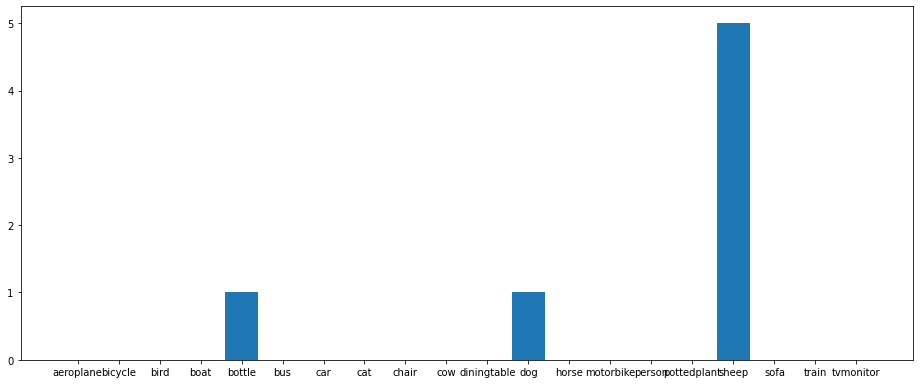

1


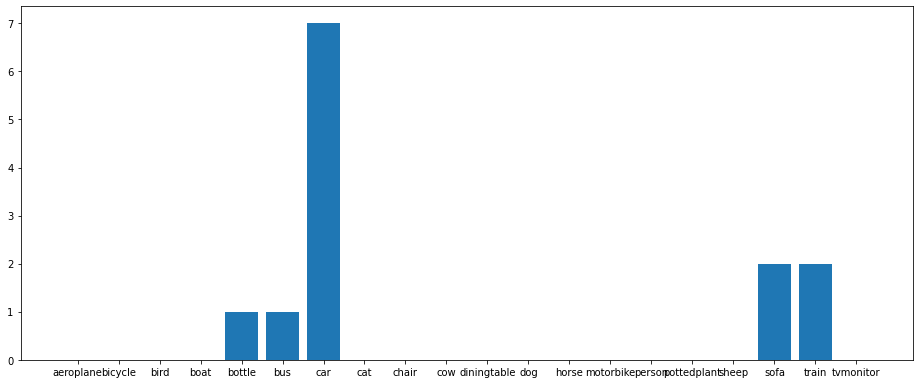

2


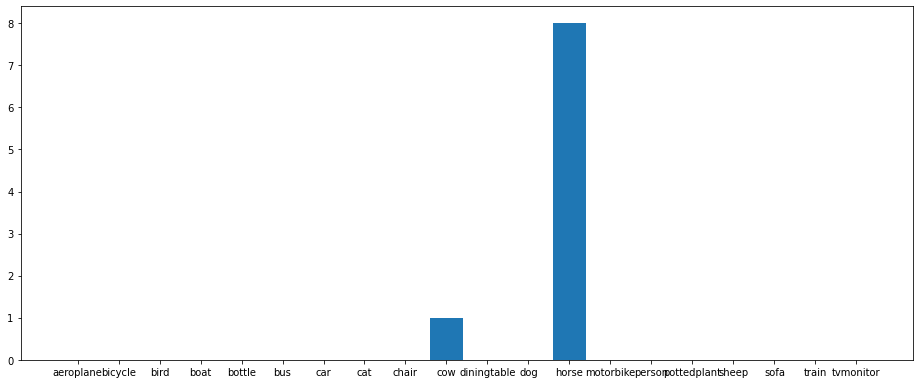

3


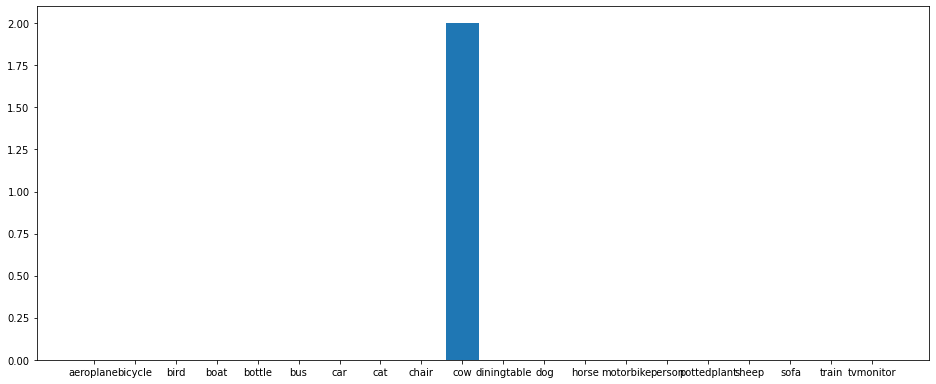

4


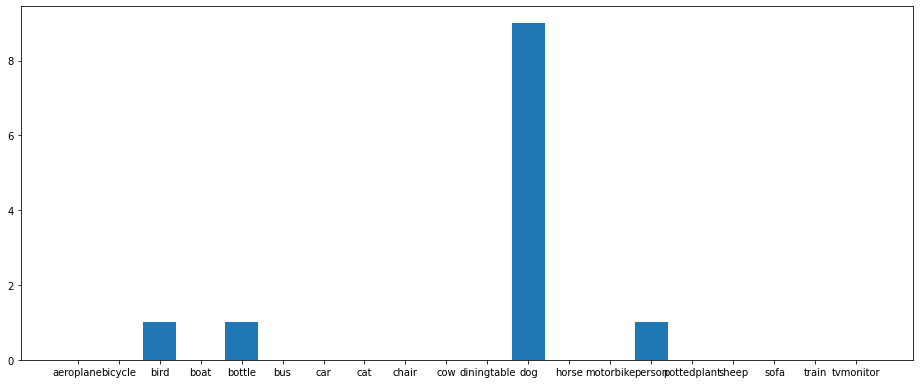

5


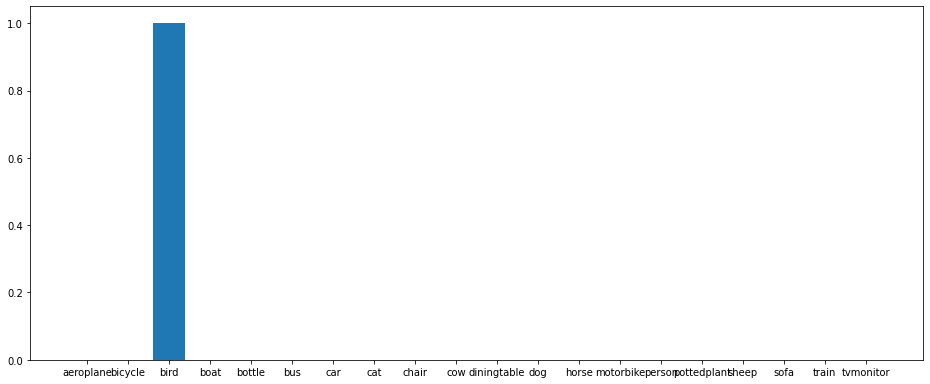

6


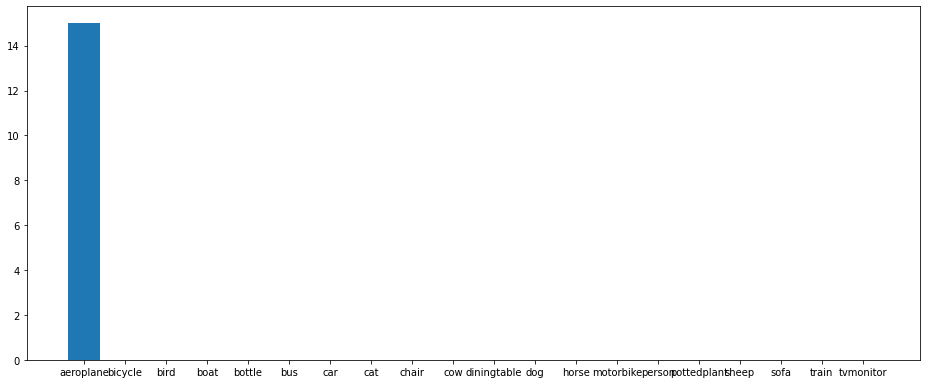

7


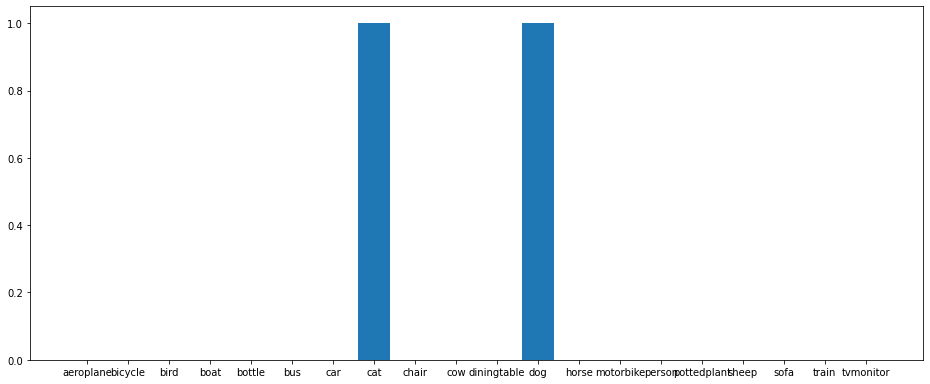

8


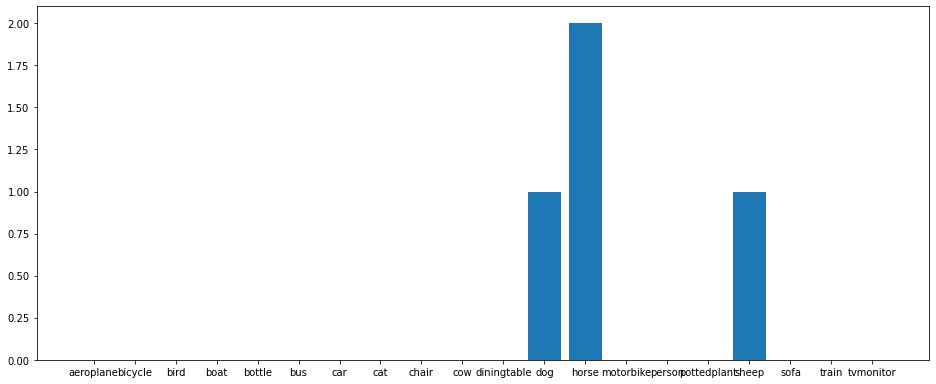

9


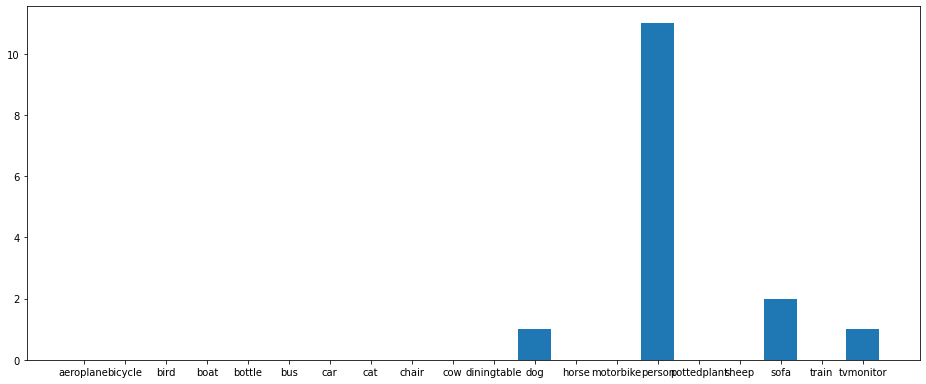

10


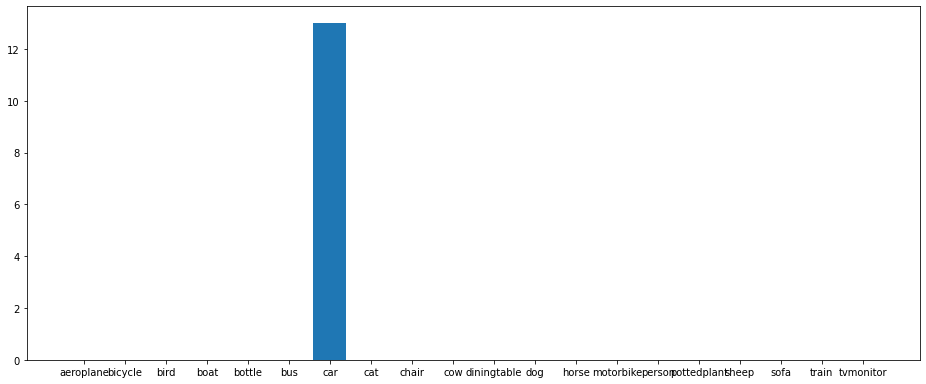

11


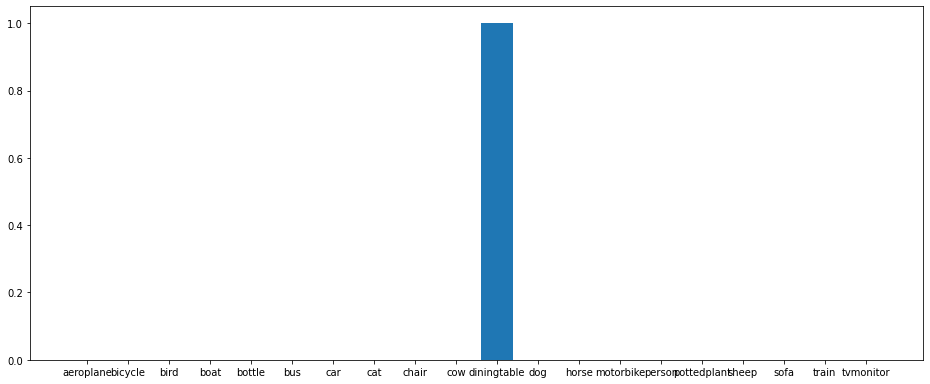

12


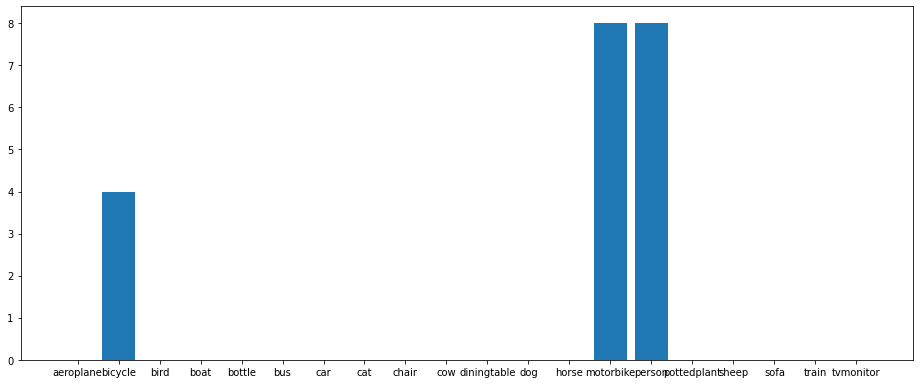

13


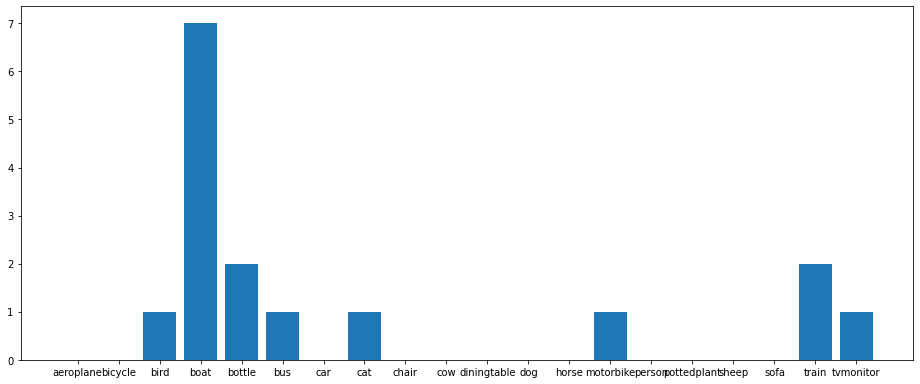

14


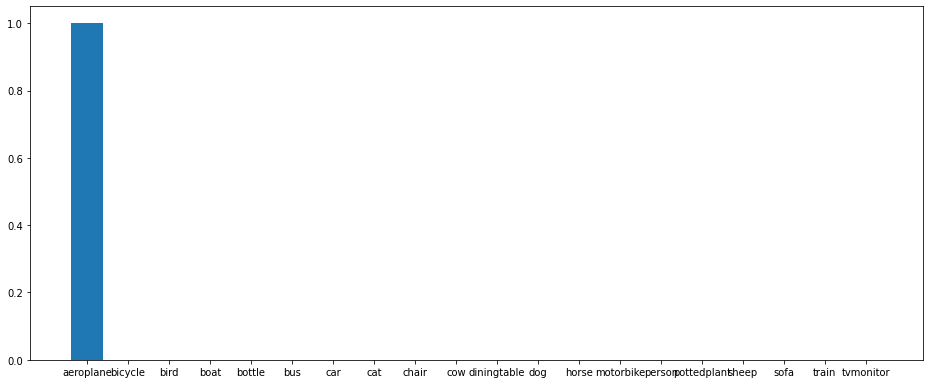

15


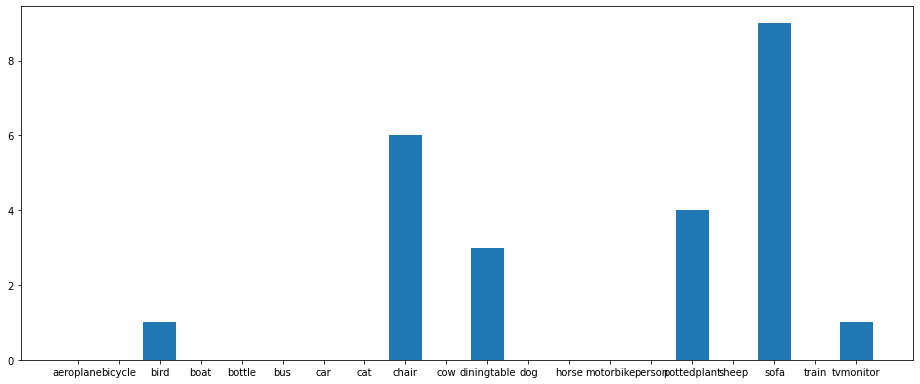

16


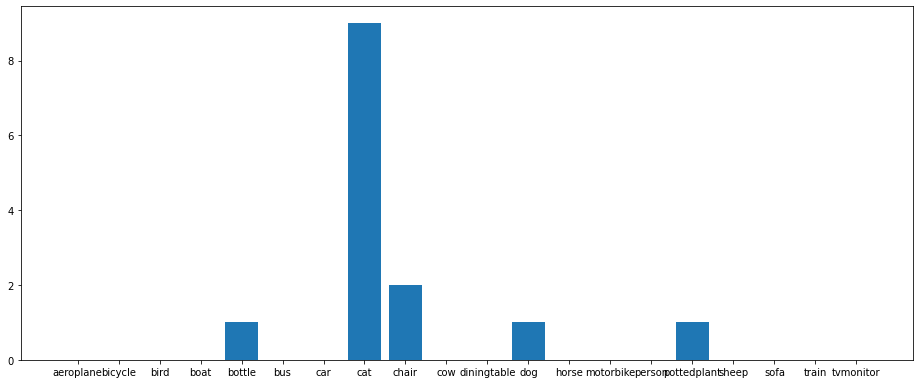

17


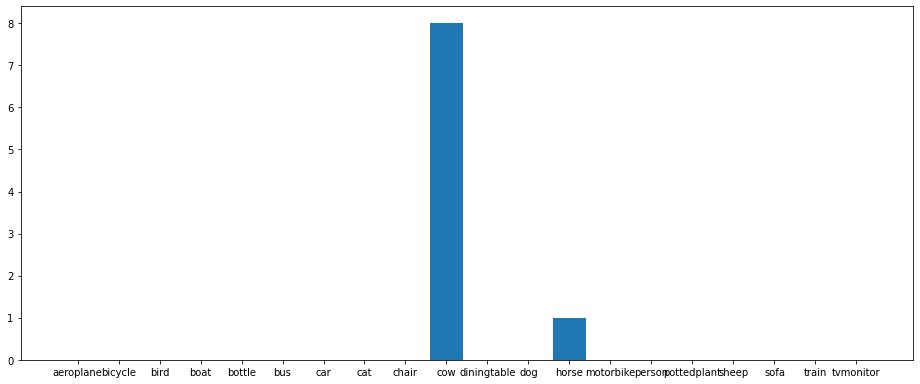

18


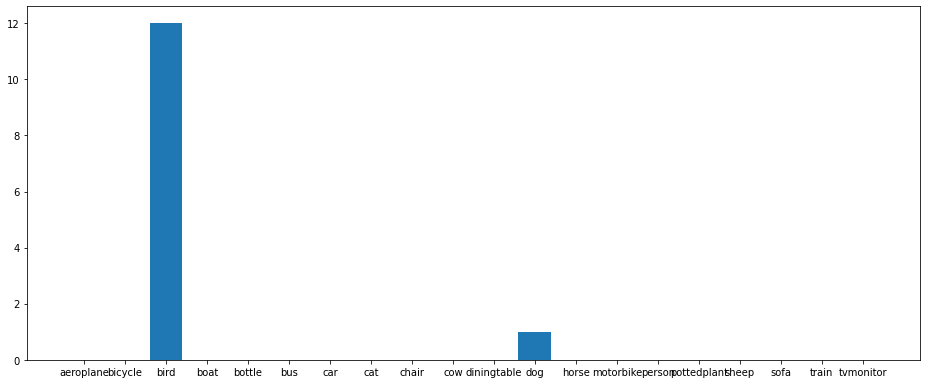

19


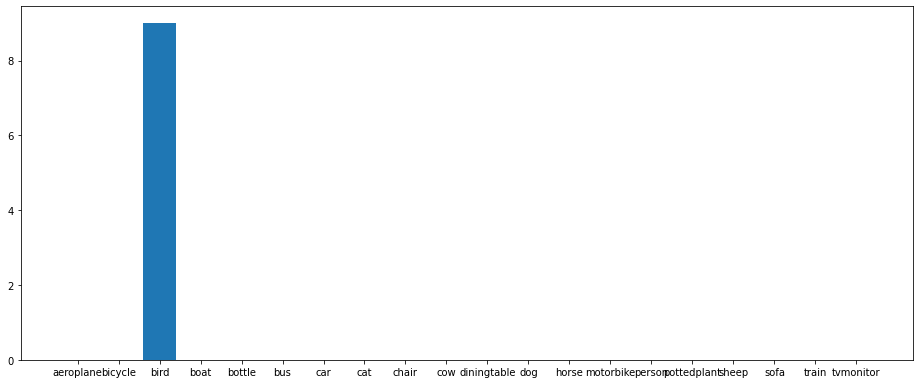

In [268]:
def cluster_histogramm(data,predicted_values,y,use_all=True):
    unique, counts = np.unique(predicted_values, return_counts=True)
    n_clusters=len(unique)
    counter=np.zeros((n_clusters,20))
    for i in range(len(predicted_values)):
        if(use_all):
            for k in data[i]["labels"]:
                    counter[predicted_values[i],k]+=1
        else:
            counter[predicted_values[i],y[i]]+=1
            
    return counter
hist=cluster_histogramm(train_filtered_list,pck.labels_,y,use_all=False)

for i in range(hist.shape[0]):  
    print(i)
    fig = plt.gcf()
    fig.set_size_inches(16, 6.5)
    plt.bar(np.arange(0,20),hist[i],tick_label=_VOC_LABELS) 
    plt.show()

In [269]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
def classifier_function_creator(clusterer,distance_measure):
    cluster_algo=clusterer
    dist_func=distance_measure
    def classifier_function(image):
        image*=255.0
        ds=tf.data.Dataset.from_tensor_slices({"image":image})
        feature= add_features_to_dataset(ds,None).map(lambda x:x["feature"]).batch(image.shape[0]).get_single_element()
        
        dist= dist_func(feature,cluster_algo.cluster_centers_)

        dist=1/dist
        dist=np.power(dist,20)
        dist=dist/np.sum(dist,axis=1,keepdims=True)
        return dist
    return classifier_function
    

func1=classifier_function_creator(pck,euclidean_distances)
print(func1(np.expand_dims(train_filtered_list[0]["image"],axis=0)/255.0))
#func2=clasifier_function_creator(pck,cosine_distances)
#func2(np.expand_dims(train_filtered_list[0]["image"],axis=0)/255.0)
#print(func1(np.expand_dims(train_filtered_list[0]["image"],axis=0)/255.0))


[[6.02883892e-05 3.14448567e-04 1.83941188e-03 4.74683445e-05
  2.19785278e-04 7.74585032e-07 1.75818961e-05 8.36481208e-06
  9.95308976e-01 4.64490891e-04 3.12648238e-05 6.66221499e-06
  3.90730008e-04 9.99240604e-05 9.14365779e-07 1.79006241e-04
  1.61283225e-04 7.00047728e-04 1.22950045e-04 2.56262158e-05]]


In [270]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

clf2 = RandomForestClassifier(max_depth=10, random_state=0)

from sklearn.metrics import accuracy_score


def classifier_function_creator2(classifier,features,labels):
    clf=classifier
    clf.fit(features,labels)
    print(accuracy_score(clf.predict(features),labels))
    def classifier_function(image):
        image*=255.0
        ds=tf.data.Dataset.from_tensor_slices({"image":image})
        feature= add_features_to_dataset(ds,None).map(lambda x:x["feature"]).batch(image.shape[0]).get_single_element()
        return clf.predict_proba(feature)
    
    return classifier_function


In [271]:

#this rewrits the functioniality of the datset transform an is approximalty 20 percent faster for batch size 100. Must be extended by other features though
#unused currently has to be rewritten
def classifier_function4(image):
    image=image*255.0
    print(image.shape)
    output=[];
    if CLD_ENABLED:
        cld=[]
        for im in image:
            cld.append(color_layout_descriptor(im))
        output.append(np.array(cld))
    if EFFNET_ENABLED:
        output.append( effnet(tf.image.resize(image, [240, 240])))
        
    for i in range(len(output)):
        output[i]=feature_weights[i]*output[i]
        
    feature = np.concatenate(output,axis=1)
    dist=kmeans.transform(feature)
    dist=1/dist
    dist=np.power(dist,20)
    dist=dist/np.sum(dist,axis=1,keepdims=True)
    return dist

from lime import lime_image

explainer = lime_image.LimeImageExplainer()

explained_index=0
explanation1 = explainer.explain_instance(train_filtered_list[explained_index]["image"]/255.0, classifier_function_creator(pck,euclidean_distances),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=1000,batch_size =250)
    


  0%|          | 0/1000 [00:00<?, ?it/s]

In [272]:
#pred =kmeans.predict(features)
#print(pred[explained_index])
print(pck.labels_[explained_index])

8


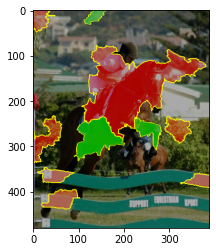

In [273]:

from skimage.segmentation import mark_boundaries
temp, mask = explanation1.get_image_and_mask(4, positive_only=False, num_features=25, hide_rest=False)
plt.imshow(mark_boundaries(temp/1.5, mask))

In [274]:
explanation2 = explainer.explain_instance(train_filtered_list[explained_index]["image"]/255.0, classifier_function_creator2(clf2,features,pck.labels_),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=1000,batch_size =250)

1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

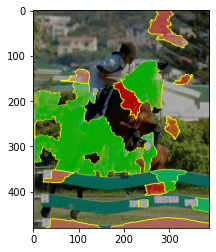

In [275]:
from skimage.segmentation import mark_boundaries
temp2, mask2 = explanation2.get_image_and_mask(4, positive_only=False, num_features=25, hide_rest=False)
plt.imshow(mark_boundaries(temp2/1.5, mask2))

In [ ]:
#Here follow test for single features they can probably removed later 

In [ ]:
#These results were not very good
#Lets test this other clustering method

from sklearn.cluster import AgglomerativeClustering,DBSCAN
from scipy.sparse.csgraph import shortest_path
from scipy.spatial import distance
dist=distance.cdist(features,features)
for c in pairwise_constraints[0]:
    dist[c[0],c[1]]=0.00001
    dist[c[1],c[0]]=0.00001
dist=shortest_path(dist)
maxdist=dist.max()
for c in pairwise_constraints[1]:
    dist[c[0],c[1]]=maxdist+1
    dist[c[1],c[0]]=maxdist+1

In [ ]:
preds = AgglomerativeClustering(n_clusters=20,linkage='complete',affinity="precomputed").fit_predict(dist)
metrics.adjusted_rand_score(y, preds)


In [ ]:
pred = AgglomerativeClustering(n_clusters=20,linkage='complete').fit_predict(features)
metrics.adjusted_rand_score(y, pred)

In [ ]:
x = np.array(list(train_filtered.map(lambda x: x['effnet']).as_numpy_iterator()), dtype=np.float64)
kmeans = KMeans(n_clusters=20, random_state=2).fit(x)
metrics.adjusted_rand_score(kmeans.predict(x), y)



In [ ]:
pred = AgglomerativeClustering(n_clusters=20,linkage='complete').fit_predict(features)
metrics.adjusted_rand_score(y, pred)

In [ ]:
explanation2 = explainer.explain_instance(train_filtered_list[explained_index]["image"]/255.0, classifier_function_creator2(clf2,features,pck.labels_),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=1000,batch_size =250)

In [ ]:
images = list(train_complete.map(lambda x: x['image']).as_numpy_iterator())

In [ ]:
#Shap does not appear to work properly right now
print(train_filtered_list[0]["image"].shape)

masker = shap.maskers.Image("inpaint_telea", train_filtered_list[0]["image"].shape)

explainer = shap.Explainer(classifier_function_creator(pck,euclidean_distances), masker, output_names=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

shap_values = explainer(np.expand_dims(train_filtered_list[0]["image"]/255.0,axis=0), max_evals=500, batch_size=250, outputs=shap.Explanation.argsort.flip[:20])

In [ ]:
explanation2 = explainer.explain_instance(train_filtered_list[explained_index]["image"]/255.0, classifier_function_creator2(clf2,features,pck.labels_),labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], top_labels=20, hide_color=0, num_samples=1000,batch_size =250)

In [ ]:
from skimage.segmentation import mark_boundaries
temp2, mask2 = explanation2.get_image_and_mask(5, positive_only=False, num_features=25, hide_rest=False)
plt.imshow(mark_boundaries(temp2/1.5, mask2))

In [ ]:
#Shap does not appear to work properly right now
print(train_filtered_list[0]["image"].shape)

masker = shap.maskers.Image("inpaint_telea", train_filtered_list[0]["image"].shape)

explainer = shap.Explainer(classifier_function_creator(pck,euclidean_distances), masker, output_names=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

shap_values = explainer(np.expand_dims(train_filtered_list[0]["image"]/255.0,axis=0), max_evals=500, batch_size=250, outputs=shap.Explanation.argsort.flip[:20])

In [ ]:

shap.image_plot(shap_values)

In [ ]:
#Here follow test for single features they can probably removed later 

In [ ]:
x = np.array(list(train_filtered.map(lambda x: x['effnet']).as_numpy_iterator()), dtype=np.float64)
kmeans = KMeans(n_clusters=20, random_state=2).fit(x)
metrics.adjusted_rand_score(kmeans.predict(x), y)



In [ ]:
pred = AgglomerativeClustering(n_clusters=20,linkage='complete').fit_predict(features)
metrics.adjusted_rand_score(y, pred)

In [ ]:
x = np.array(list(train_complete.map(lambda x: x['effnet']).as_numpy_iterator()), dtype=np.float64)
kmeans = KMeans(n_clusters=20, random_state=2).fit(x)
metrics.adjusted_rand_score(kmeans.predict(x), y)



In [ ]:
x2 = np.array(list(train_filtered.map(lambda x: x['cld']).as_numpy_iterator()), dtype=np.float64)
#scaler=RobustScaler()
#x2 = scaler.fit_transform(x2)

In [ ]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(x)

In [ ]:
if EFFNET_ENABLED:
    counter = 0
    for data in val_complete:
        if counter == 10:
            break
        im = data['image']
        feature = data['effnet']
        pred = kmeans.predict(tf.reshape(feature, (1, -1)))
        for i in range(pred.shape[0]):
            if pred[i] == 4:
                plt.imshow(im)
                plt.show()
                counter += 1
                if counter == 10:
                    break

In [ ]:
x2 = np.array(list(train_complete.map(lambda x: x['cld']).as_numpy_iterator()), dtype=np.float64)
#scaler=RobustScaler()
#x2 = scaler.fit_transform(x2)

In [ ]:
kmeans2 = KMeans(n_clusters=20, random_state=0).fit(x2)

In [ ]:
if CLD_ENABLED:
    counter = 0
    for data in val_complete:
        if counter == 10:
            break
        im = data['image']
        feature = data['cld']
        pred = kmeans2.predict(tf.reshape(feature, (1, -1)))
        for i in range(pred.shape[0]):
            if pred[i] == 2:
                plt.imshow(im)
                plt.show()
                counter += 1
                if counter == 10:
                    break

In [ ]:
i=0
if CLD_ENABLED:
    counter = 0
    for data in train_filtered:
        if counter == 10:
            break
        im = data['image']
        feature = data['cld']

        if preds[i] == 0:
            plt.imshow(im)
            plt.show()
            counter += 1
            if counter == 10:
                break
        i+=1

In [ ]:
# cdf values have way higher variance (x150000)
weight_cdf = 0.01
x3 = np.array(
    list(train_filtered.map(lambda x: tf.concat((x['cld'] * weight_cdf, x['effnet']), axis=0)).as_numpy_iterator()),
    dtype=np.float64)

In [ ]:
# cdf values have way higher variance (x150000)
weight_cdf = 0.01
x3 = np.array(
    list(train_filtered.map(lambda x: tf.concat((x['cld'] * weight_cdf, x['effnet']), axis=0)).as_numpy_iterator()),
    dtype=np.float64)

In [ ]:
i=0
if CLD_ENABLED:
    counter = 0
    for data in train_complete:
        if counter == 10:
            break
        im = data['image']
        feature = data['cld']

        if preds[i] == 0:
            plt.imshow(im)
            plt.show()
            counter += 1
            if counter == 10:
                break
        i+=1

In [ ]:
# cdf values have way higher variance (x150000)
weight_cdf = 0.01
x3 = np.array(
    list(train_complete.map(lambda x: tf.concat((x['cld'] * weight_cdf, x['effnet']), axis=0)).as_numpy_iterator()),
    dtype=np.float64)

In [ ]:
# cdf values have way higher variance (x150000)
weight_cdf = 0.01
x3 = np.array(
    list(train_complete.map(lambda x: tf.concat((x['cld'] * weight_cdf, x['effnet']), axis=0)).as_numpy_iterator()),
    dtype=np.float64)

In [ ]:

np.var(x3[:, 192:])

In [ ]:
kmeans3 = KMeans(n_clusters=20, random_state=0).fit(x3)

In [ ]:
if CLD_ENABLED and EFFNET_ENABLED:
    counter = 0
    for data in val_complete:
        if counter == 10:
            break
        im = data['image']
        feature = tf.concat((data['cld'] * weight_cdf, data['effnet']), axis=0)
        pred = kmeans3.predict(tf.reshape(feature, (1, -1)))
        for i in range(pred.shape[0]):
            if pred[i] == 3:
                plt.imshow(im)
                plt.show()
                counter += 1
                if counter == 10:
                    break
